In [1]:
! pip install git+https://github.com/csebuetnlp/normalizer
! pip install transformers
! pip install sentencepiece
!pip install gdown

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-v8a5i2ji
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-v8a5i2ji
  Resolved https://github.com/csebuetnlp/normalizer to commit d80c3c484e1b80268f2b2dfaf7557fe65e34f321
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6883 sha256=5df82847f6983651b3f4d51e9a4f1477bf6f2dd0b8a0d741fc15aaa79e58d320
  Stored in directory: /tmp/pip-ephem-wheel-cache-abezls7c/wheels/af/b1/ee/b9e2a2f2dd861976a357b6a6fa105aeedf2254016676f6cf8f
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=32db9e489b301194c74813eced3b

In [2]:
import gdown
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, T5ForConditionalGeneration
from normalizer import normalize 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import gc
import torch.nn as nn
import time
import copy
import datasets
torch.manual_seed(42)

In [3]:
url = 'https://drive.google.com/uc?id=1w7gOH4lW0Z4Pmqm4wI_j96bWFXYpJWsM'
output = 'new-dataset-76K.xlsx'
gdown.download(url, output, quiet=False)

# url = 'https://drive.google.com/uc?id=1kXPYLQYovziPjA4_cgdz87xKDXwrc6Zp'
# output = 'best-checkpoint.ckpt'
# gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1w7gOH4lW0Z4Pmqm4wI_j96bWFXYpJWsM
To: /kaggle/working/new-dataset-76K.xlsx
100%|██████████| 160M/160M [00:01<00:00, 93.9MB/s]


'new-dataset-76K.xlsx'

In [4]:
df = pd.read_excel('new-dataset-76K.xlsx')
df = df.dropna()
df = df.reset_index()
df.head()

,index,text,extractive,summary
0,0,"ঢাকা মহানগর ও ঢাকা জেলা আদালত, কিশোরগঞ্জ ও রাঙ...",আজ শনিবার ঢাকা মহানগর দায়রা জজ আদালতের জগন্নাথ...,অ্যাপসে মিলবে ঢাকাসহ তিন জেলা আদালতের তথ্য
1,1,যুক্তরাষ্ট্রে বিজ্ঞান ও প্রকৌশলে পেশা শুরুর প...,বাংলাদেশ প্রকৌশল বিশ্ববিদ্যালয়ের সাবেক শিক্ষা...,বিজ্ঞান ও প্রকৌশলে মার্কিন সর্বোচ্চ সম্মাননা...
2,2,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য ও বাণিজ্যিকভাবে উত্পাদিত শিশু...,বিকল্প শিশুখাদ্য গ্রহণে শিশুর মৃত্যু হলে শাস্ত...
3,3,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,বগুড়ার আদমদীঘির সান্তাহারে গতকাল শনিবার ট্রেন...,ট্রেনে কাটা পড়ে সাবেক সিভিল সার্জনের মৃত্যু
4,4,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীর একটি রেস্তোরাঁয় গতকাল বুধবার ভোর...,যাত্রাবাড়ীতে চুলা জ্বালাতে গিয়ে দুই কর্মচারী ...


In [5]:
print(df.shape)
df = df.drop_duplicates(subset=['extractive'])
print(df.shape)

(76559, 4)
(76487, 4)


In [6]:
train_df, test_df = train_test_split(df, test_size=0.30, random_state=1)
train_df, val_df = train_test_split(train_df, test_size=0.10, random_state=1)
train_df = train_df.reset_index()
test_df = test_df.reset_index()
val_df = val_df.reset_index()
print(train_df.shape, test_df.shape, val_df.shape)

(48186, 5) (22947, 5) (5354, 5)


In [7]:
class SummeryDataset(Dataset):

  def __init__(
      self, data: pd.DataFrame,
      tokenizer: AutoTokenizer,
      text_max_token_len: int = 512,
      summary_max_token_len: int = 128,
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row['extractive']
    summary = data_row['summary']

    text_encoding = tokenizer(
        normalize(text),
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        add_special_tokens=True,
        return_tensors="pt"
      )
    
    summary_encoding = tokenizer(
        normalize(summary),
        max_length=self.summary_max_token_len,
        padding="max_length",
        truncation=True,
        add_special_tokens=True,
        return_tensors="pt"
      )

    labels = summary_encoding['input_ids']
    labels[labels == 0] = -100

    return text_encoding['input_ids'].flatten(), text_encoding['attention_mask'].flatten(), labels.flatten(), summary_encoding['attention_mask'].flatten()

In [8]:
model_name = "csebuetnlp/banglat5"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

In [9]:
train_dataset = SummeryDataset(
        train_df,
        tokenizer,
        text_max_token_len = 512,
        summary_max_token_len = 30
    )

test_dataset = SummeryDataset(
        test_df,
        tokenizer,
        text_max_token_len = 512,
        summary_max_token_len = 30
    )

validation_dataset = SummeryDataset(
        val_df,
        tokenizer,
        text_max_token_len = 512,
        summary_max_token_len = 30
    )

In [10]:
train_loader = DataLoader(
    train_dataset, shuffle = True, batch_size = 8, drop_last=True, num_workers=2
)

test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle = False, drop_last=True, num_workers=2
)

validation_loader = DataLoader(
    validation_dataset, shuffle = False, batch_size = 8, drop_last=True, num_workers=2
)

In [11]:
dataloaders = {"train" : train_loader,
               "val" : validation_loader}

In [12]:
class MyTaskSpecificCustomModel(nn.Module):

    def __init__(self, checkpoint):
        super(MyTaskSpecificCustomModel, self).__init__()
        
        self.model = T5ForConditionalGeneration.from_pretrained(checkpoint, return_dict=True)


        
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
        input_ids,
        attention_mask = attention_mask,
        labels = labels,
        decoder_attention_mask = decoder_attention_mask
      ) 
        
        return output.loss, output.logits

In [13]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dml

device(type='cuda', index=0)

In [14]:
base_model = MyTaskSpecificCustomModel(checkpoint=model_name).to(dml)
# base_model

In [15]:
num_epochs = 4
learning_rate = 0.0001
optimizer = torch.optim.AdamW(base_model.parameters(), lr=learning_rate)

In [16]:
validation_loss = []
training_loss = []



def train_model():
    since = time.time()
    
    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_loss = 10000.0
    
    progress_bar_train = tqdm(range(num_epochs * len(train_loader)))
    progress_bar_eval = tqdm(range(num_epochs * len(validation_loader)))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                base_model.train()  # Set model to training mode
            else:
                base_model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0

            # Iterate over data.
            for text_input_ids, text_attention_mask, labels, labels_attention_mask in dataloaders[phase]:
                
                text_input_ids = text_input_ids.to(dml)
                text_attention_mask = text_attention_mask.to(dml)
                labels = labels.to(dml)
                labels_attention_mask = labels_attention_mask.to(dml)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): 
                    loss, output = base_model(input_ids = text_input_ids,
                               attention_mask = text_attention_mask,
                               decoder_attention_mask = labels_attention_mask,
                               labels = labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        progress_bar_train.update(1)
                    elif phase == 'val':
                        progress_bar_eval.update(1)
                        
                running_loss += loss.item() * len(labels)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'train':
                training_loss.append(epoch_loss)
            elif phase == 'val':
                validation_loss.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(base_model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    base_model.load_state_dict(best_model_wts)
    return base_model

In [17]:
best_model = train_model()

  0%|          | 0/24092 [00:00<?, ?it/s]

  0%|          | 0/2676 [00:00<?, ?it/s]

Epoch 0/3
----------
train Loss: 4.7696
val Loss: 2.8988

Epoch 1/3
----------
train Loss: 3.2207
val Loss: 2.4654

Epoch 2/3
----------
train Loss: 2.7650
val Loss: 2.3006

Epoch 3/3
----------
train Loss: 2.4916
val Loss: 2.2302

Training complete in 258m 43s
Best val loss: 2.230196


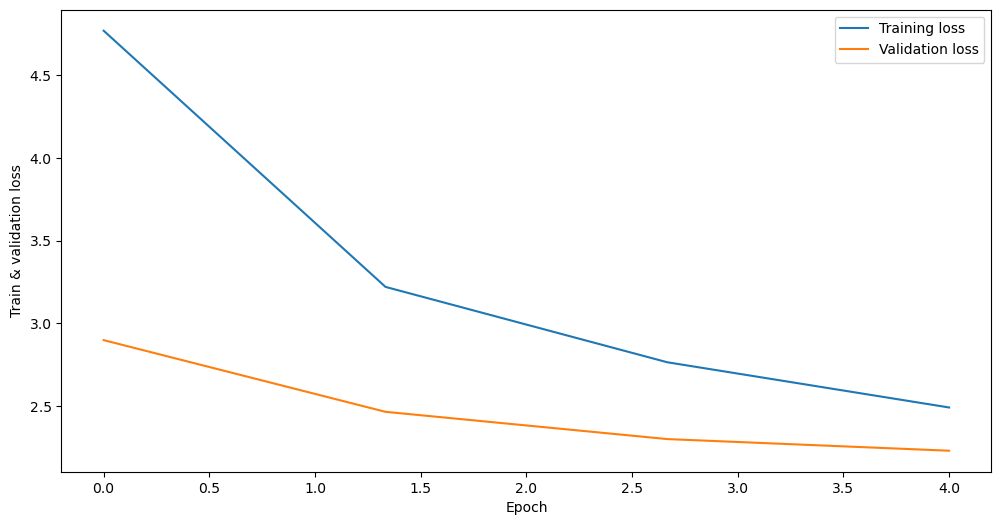

In [18]:
x = torch.linspace(0, num_epochs, num_epochs)
plt.figure(figsize=(12,6))
plt.plot(x, training_loss)
plt.plot(x, validation_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("Epoch")
plt.ylabel("Train & validation loss")
plt.show()

In [19]:
model_path = 'trained.pt'
torch.save(best_model.state_dict(), model_path)